# Analysing memory usage in Cubed

We'll run a small computation with large chunks using Lithops in local mode.

In [1]:
import logging

import numpy as np
import pandas as pd
from tqdm.contrib.logging import logging_redirect_tqdm

import cubed
import cubed.array_api as xp
import cubed.random
from cubed.extensions.history import HistoryCallback
from cubed.extensions.tqdm import TqdmProgressBar
from cubed.runtime.executors.lithops import LithopsDagExecutor

In [2]:
logging.basicConfig(level=logging.INFO)
# turn off lithops own progress bar
logging.getLogger("lithops.wait").setLevel(logging.WARNING)
# suppress harmless connection pool warnings
logging.getLogger("urllib3.connectionpool").setLevel(logging.ERROR)

LITHOPS_LOCAL_CONFIG = {"lithops": {"backend": "localhost", "storage": "localhost"}}

In [3]:
spec = cubed.Spec(None, allowed_mem=2_000_000_000)
executor = LithopsDagExecutor(config=LITHOPS_LOCAL_CONFIG)

In [4]:
a = cubed.random.random(
    (10000, 10000), chunks=(5000, 5000), spec=spec
)  # 200MB chunks
b = cubed.random.random(
    (10000, 10000), chunks=(5000, 5000), spec=spec
)  # 200MB chunks
c = xp.astype(a, xp.float32)
d = xp.astype(b, xp.float32)
e = xp.matmul(c, d)

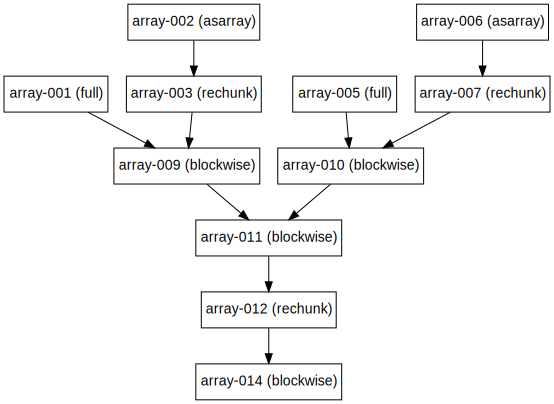

In [5]:
e.visualize()

Run the computation

In [6]:
with logging_redirect_tqdm():
    progress = TqdmProgressBar()
    hist = HistoryCallback()
    e.compute(
        return_stored=False,
        executor=executor,
        callbacks=[progress, hist],
    )

array-003:   0%|          | 0/1 [00:00<?, ?it/s]

array-007:   0%|          | 0/1 [00:00<?, ?it/s]

array-009:   0%|          | 0/4 [00:00<?, ?it/s]

array-010:   0%|          | 0/4 [00:00<?, ?it/s]

array-011:   0%|          | 0/8 [00:00<?, ?it/s]

array-012:   0%|          | 0/4 [00:00<?, ?it/s]

array-014:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:lithops.config:Lithops v2.6.0
INFO:lithops.storage.backends.localhost.localhost:Localhost storage client created
INFO:lithops.localhost.localhost:Localhost compute client created
INFO:lithops.invokers:ExecutorID 5de609-0 | JobID M000 - Selected Runtime: python3.8 
INFO:lithops.invokers:ExecutorID 5de609-0 | JobID M000 - Starting function invocation: sf() - Total: 1 activations
INFO:lithops.invokers:ExecutorID 5de609-0 | JobID M000 - View execution logs at /private/var/folders/jz/_qsj6p5j2gg4s064yzhrbtcw0000gn/T/lithops/logs/5de609-0-M000.log
INFO:lithops.storage.backends.localhost.localhost:Localhost storage client created
INFO:lithops.invokers:ExecutorID 5de609-0 | JobID M001 - Selected Runtime: python3.8 
INFO:lithops.invokers:ExecutorID 5de609-0 | JobID M001 - Starting function invocation: sf() - Total: 1 activations
INFO:lithops.invokers:ExecutorID 5de609-0 | JobID M001 - View execution logs at /private/var/folders/jz/_qsj6p5j2gg4s064yzhrbtcw0000gn/T/lithops/logs/5de609-0-M001

In [7]:
! ls -l history

total 16
-rw-r--r--  1 tom  staff   246 16 Jul 12:42 plan-1657971758.csv
-rw-r--r--  1 tom  staff  2799 16 Jul 12:42 stats-1657971758.csv


Analyse memory usage

In [8]:
plan_df = pd.read_csv("history/plan-1657971758.csv")
stats_df = pd.read_csv("history/stats-1657971758.csv")

# convert memory to MB
plan_df["required_mem_mb"] = plan_df["required_mem"] / 1_000_000
plan_df = plan_df[["array_name", "op_name", "required_mem_mb", "num_tasks"]]
stats_df["peak_mem_start_mb"] = stats_df["peak_memory_start"] / 1_000_000
stats_df["peak_mem_end_mb"] = stats_df["peak_memory_end"] / 1_000_000
stats_df["peak_mem_delta_mb"] = (
    stats_df["peak_mem_end_mb"] - stats_df["peak_mem_start_mb"]
)

# find per-array stats
df = stats_df.groupby("array_name", as_index=False).agg(
    {
        "peak_mem_end_mb": ["max"],
        "peak_mem_delta_mb": ["min", "mean", "max"],
    }
)

# flatten multi-index and merge with plan
df.columns = ["_".join(a).rstrip("_") for a in df.columns.to_flat_index()]
df = df.merge(plan_df, on="array_name")

# calculate max memory utilization
def max_mem_utilization(row):
    if row["required_mem_mb"] < 1:
        # numbers are not meaningful for small arrays
        return np.nan
    return 100.0 * row["peak_mem_delta_mb_max"] / row["required_mem_mb"]
df["max_mem_utilization"] = df.apply(lambda row: max_mem_utilization(row), axis=1)

df

,array_name,peak_mem_end_mb_max,peak_mem_delta_mb_min,peak_mem_delta_mb_mean,peak_mem_delta_mb_max,op_name,required_mem_mb,num_tasks,max_mem_utilization
0,array-003,108.081152,0.086016,0.086016,0.086016,rechunk,0.000064,1,NaN
1,array-007,108.306432,0.069632,0.069632,0.069632,rechunk,0.000064,1,NaN
2,array-009,409.182208,300.244992,300.250112,300.257280,blockwise,800.000008,4,37.532160
3,array-010,409.280512,300.240896,300.241920,300.244992,blockwise,800.000008,4,37.530624
4,array-011,640.409600,439.459840,467.297280,531.382272,blockwise,600.000000,8,88.563712
5,array-012,862.490624,654.827520,704.568320,754.323456,rechunk,800.000000,4,94.290432
6,array-014,541.310976,432.332800,432.467968,432.603136,blockwise,600.000000,4,72.100523
